# Cryptocurrency Price Prediction using Neural Networks
This project presents a comprehensive approach to predicting cryptocurrency prices using neural networks. The project begins with data collection from the CryptoCompare API, focusing on Bitcoin price data. Following this, the data is preprocessed, including feature scaling and sequence creation for input into the neural network model. The model architecture consists of Long Short-Term Memory (LSTM) layers, known for their ability to capture sequential patterns in time-series data. The notebook demonstrates the training of the model, incorporating techniques such as early stopping and model checkpointing to prevent overfitting. Finally, the trained model is evaluated on a test dataset, and the results are visualized to assess its predictive performance. By following this notebook, users gain insight into the entire pipeline of building, training, and evaluating a neural network model for cryptocurrency price prediction, showcasing proficiency in machine learning techniques and deep learning frameworks.
## Step 1: Set Up the Environment
First, let's ensure we have all the necessary libraries installed. We will use pandas for data manipulation, numpy for numerical computations, matplotlib for visualization, scikit-learn for preprocessing, and tensorflow and keras for building the neural network.

In [73]:
%pip install pandas numpy matplotlib scikit-learn tensorflow keras requests

Note: you may need to restart the kernel to use updated packages.


## Step 2: Data Collection
We will use the 'cryptocompare' API to collect historical price data for Bitcoin. The following code fetches the data and stores it in a DataFrame.

In [74]:
import requests
import pandas as pd
from datetime import datetime

def get_crypto_data(symbol, limit=2000, aggregate=1):
    url = f"https://min-api.cryptocompare.com/data/v2/histoday?fsym={symbol}&tsym=USD&limit={limit}&aggregate={aggregate}"
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data['Data']['Data'])
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    return df

symbol = 'BTC'
df = get_crypto_data(symbol)
df.to_csv('crypto_data.csv')
df.head()

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2018-12-08,3602.49,3295.21,3420.57,104091.14,3.575486e+08,3461.07,direct,
2018-12-09,3718.58,3436.50,3461.07,83347.79,2.953215e+08,3592.84,direct,
2018-12-10,3645.49,3416.77,3592.84,81855.33,2.871198e+08,3467.16,direct,
2018-12-11,3483.58,3348.98,3467.16,67519.71,2.306718e+08,3401.02,direct,
2018-12-12,3545.37,3380.48,3401.02,74415.95,2.572936e+08,3485.59,direct,


## Step 3: Data Preprocessing
Next, we preprocess the data. We will focus on the closing price and scale the data using 'MinMaxScaler' to ensure our neural network performs well.

In [75]:
from sklearn.preprocessing import MinMaxScaler

def preprocess_data(file_path):
    df = pd.read_csv(file_path, index_col='time')
    df = df[['close']]  # We'll use the closing price for simplicity
    scaler = MinMaxScaler(feature_range=(0, 1))
    df['close'] = scaler.fit_transform(df[['close']])
    return df, scaler

df, scaler = preprocess_data('crypto_data.csv')
df.head()


,close
time,
2018-12-08,0.003270
2018-12-09,0.005156
2018-12-10,0.003358
2018-12-11,0.002411
2018-12-12,0.003621


## Step 4: Feature Engineering
We create sequences of a fixed length to be used as input features for our neural network. This involves creating rolling windows of historical prices.

In [76]:
import numpy as np
def create_sequences(df, sequence_length):
    sequences = []
    labels = []
    for i in range(len(df) - sequence_length):
        seq = df.iloc[i:i+sequence_length].values
        label = df.iloc[i+sequence_length].values[0]
        sequences.append(seq)
        labels.append(label)
    return sequences, labels

sequence_length = 60
sequences, labels = create_sequences(df, sequence_length)
sequences = np.array(sequences)
labels = np.array(labels)
sequences.shape, labels.shape

((1941, 60, 1), (1941,))

## Step 5: Model Building
We define our neural network model using Keras. The model consists of LSTM layers, dropout layers for regularization, and a dense output layer.

In [77]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_model((sequences.shape[1], sequences.shape[2]))
model.summary()


/home/nirn/miniconda3/envs/operations_research/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

## Step 6: Model Training
We split the data into training and testing sets, then train the model using the training data. We also use early stopping and model checkpointing to avoid overfitting.

In [78]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

train_size = int(len(sequences) * 0.8)
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
model_checkpoint = ModelCheckpoint('model.keras', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0412 - val_loss: 0.0017
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0018 - val_loss: 9.4742e-04
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss:

## Step 7: Model Evaluation
After training, we evaluate the model on the test set and visualize the results. We plot the actual vs predicted prices to assess the model's performance.

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6259e-04
Test Loss: 0.0006988955428823829
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


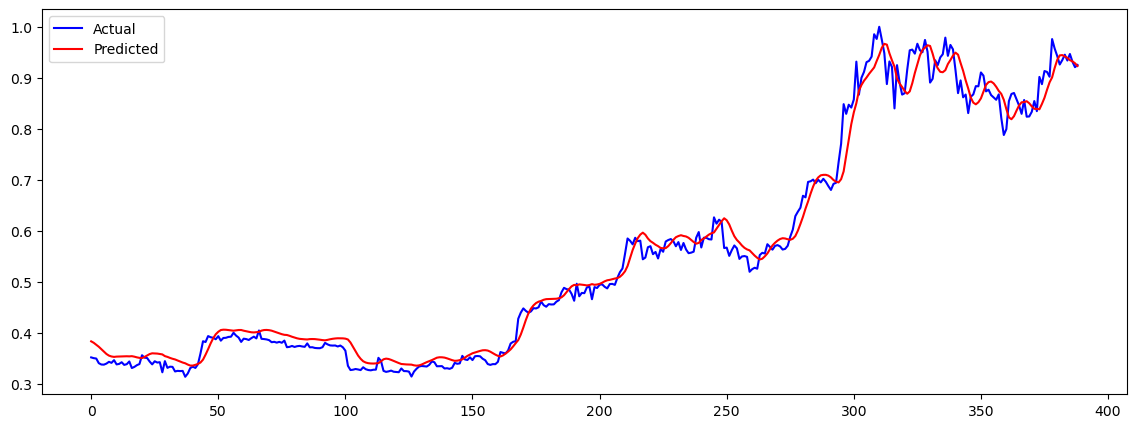

In [79]:
import matplotlib.pyplot as plt

model.load_weights('model.keras')
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

predictions = model.predict(X_test)
plt.figure(figsize=(14, 5))
plt.plot(y_test, color='blue', label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.legend()
plt.show()


## Step 8: Predicting Next Days Prices
After training our neural network model, we can extend its utility to predict cryptocurrency prices for the next several days. This involves using the model iteratively, where each predicted price is used as input for the subsequent prediction. Here's a detailed explanation of the process:
### Initialize the Prediction Sequence:
We start with the last sequence of data from our dataset. This sequence will serve as the initial input for our model.

In [80]:
last_sequence = df[-sequence_length:].values
last_sequence = np.expand_dims(last_sequence, axis=0)

### Iterative Prediction:
We specify the number of days (n_days) for which we want to predict prices.

In [81]:
n_days = 3

For each day, we:
 - Use the model to predict the next day's price.
 - Append the predicted price to our list of predictions.
 - Update the input sequence by appending the new predicted price and removing the oldest price in the sequence.
 - Generate Dates for Predictions.
 - The model's output is in the scaled format. Convert these scaled predictions back to their original dollar values using the scaler.

In [82]:
predicted_prices = {}
last_date = pd.to_datetime(df.index[-1])

for _ in range(n_days):
    predicted_price = model.predict(last_sequence)
    last_date = last_date + pd.Timedelta(days=1)
    predicted_prices[last_date] = scaler.inverse_transform(predicted_price)
    last_sequence = np.append(last_sequence[:, 1:, :], [predicted_price], axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


### Plot the Results:
We plot the actual prices for the last 60 days along with the predicted prices for the next n days. This visualization helps in comparing the model's predictions with the recent historical data.

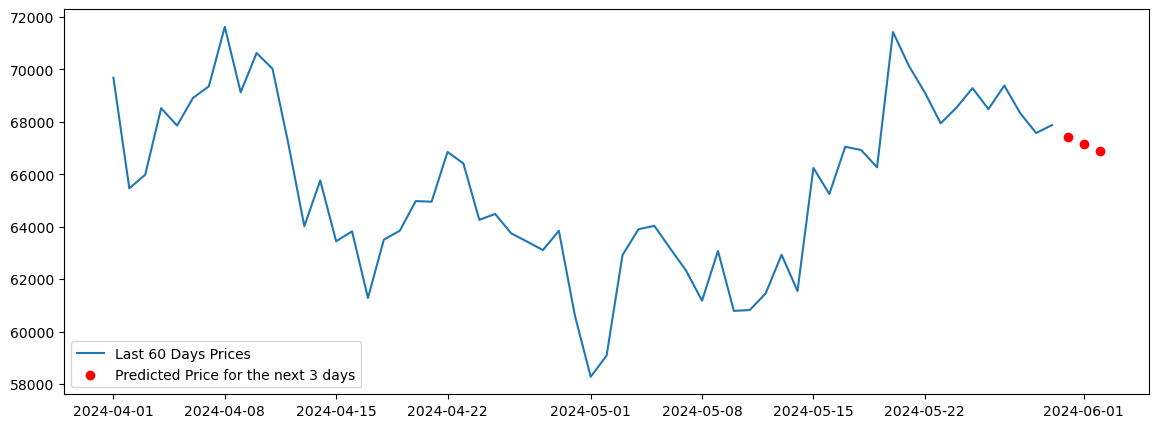

In [83]:
plt.figure(figsize=(14, 5))
dollar_prices = scaler.inverse_transform(df[['close']])
plt.plot(pd.to_datetime(df.index[-sequence_length:]), dollar_prices[-sequence_length:], label='Last 60 Days Prices')
plt.scatter(predicted_prices.keys(), predicted_prices.values(), color='red', label=f'Predicted Price for the next {n_days} days')
plt.legend()
plt.show()


By following this approach, we extend our model's predictive capabilities to forecast future prices. This iterative prediction method can be useful for short-term trading strategies or for gaining insights into potential future price movements.